<a href="https://colab.research.google.com/github/MammadovN/Machine_Learning/blob/main/projects/03_deep_learning/autoencoders/autoencoder_anomaly_detection/autoencoder_anomaly_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import EarlyStopping

In [10]:
def load_and_preprocess_data():
    # Load ECG5000 dataset
    df = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
    data = df.values

    # Last column contains labels (0: abnormal, 1: normal)
    X = data[:, :-1]
    y = data[:, -1]

    # Separate normal and abnormal data
    X_normal = X[y == 1]
    X_abnormal = X[y == 0]

    # Train-test split (only normal data used for training)
    X_train, X_test_normal = train_test_split(X_normal, test_size=0.2, random_state=42)
    X_test = np.concatenate([X_test_normal, X_abnormal], axis=0)
    y_test = np.concatenate([
        np.ones(X_test_normal.shape[0]),  # normal
        np.zeros(X_abnormal.shape[0])     # abnormal
    ])

    # Standardize the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return X_train, X_test, y_test

In [11]:
def build_autoencoder(input_dim):
    # Encoder
    inputs = layers.Input(shape=(input_dim,))
    x = layers.Dense(64, activation='relu')(inputs)
    x = layers.Dense(32, activation='relu')(x)
    latent = layers.Dense(16, activation='relu')(x)

    # Decoder
    x = layers.Dense(32, activation='relu')(latent)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(input_dim, activation='sigmoid')(x)

    return Model(inputs, outputs)

In [12]:
def find_optimal_threshold(recon_error, y_true):
    thresholds = np.linspace(recon_error.min(), recon_error.max(), 100)
    best_f1 = 0
    best_threshold = 0

    for threshold in thresholds:
        y_pred = (recon_error > threshold).astype(int)
        f1 = f1_score(y_true, y_pred)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    return best_threshold

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.1705 - val_loss: 0.8172
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9421 - val_loss: 0.7356
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8305 - val_loss: 0.7141
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7524 - val_loss: 0.6997
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7230 - val_loss: 0.6882
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7334 - val_loss: 0.6819
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7437 - val_loss: 0.6775
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7056 - val_loss: 0.6727
Epoch 9/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7490 - val_loss: 0.6676
Epoch 10/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7482 - val_loss: 0.6627
Epoch 11/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7071 - val_loss: 0.6598
Epoch 12/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.6902 - val_lo

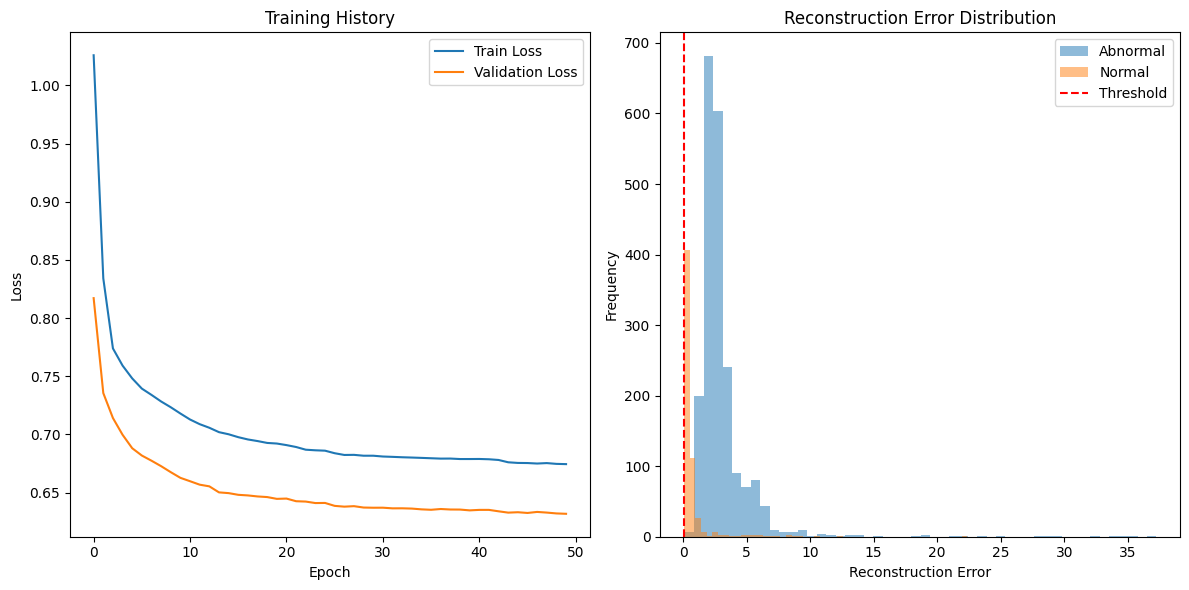

In [13]:
def main():
    # Hyperparameters
    EPOCHS = 50
    BATCH_SIZE = 32

    # Data preparation
    X_train, X_test, y_test = load_and_preprocess_data()
    input_dim = X_train.shape[1]

    # Build and compile the model
    autoencoder = build_autoencoder(input_dim)
    autoencoder.compile(optimizer='adam', loss='mse')

    # Train the model with EarlyStopping
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = autoencoder.fit(
        X_train, X_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=0.1,
        verbose=1,
        callbacks=[early_stop]
    )

    # Compute reconstruction errors
    reconstructions = autoencoder.predict(X_test)
    recon_error = np.mean(np.square(X_test - reconstructions), axis=1)

    # Find the optimal threshold
    threshold = find_optimal_threshold(recon_error, y_test)

    # Make predictions
    y_pred = (recon_error > threshold).astype(int)

    # Print evaluation metrics
    print(f"Optimal Threshold: {threshold:.4f}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")

    # Visualizations
    plt.figure(figsize=(12, 6))

    # Training loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Reconstruction error distribution
    plt.subplot(1, 2, 2)
    plt.hist(recon_error[y_test == 0], bins=50, alpha=0.5, label='Abnormal')
    plt.hist(recon_error[y_test == 1], bins=50, alpha=0.5, label='Normal')
    plt.axvline(threshold, color='r', linestyle='--', label='Threshold')
    plt.title('Reconstruction Error Distribution')
    plt.xlabel('Reconstruction Error')
    plt.ylabel('Frequency')
    plt.legend()

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()